# Es. 1: 

Scrivere una funzione `drop n l` che prende un intero e una lista, e scarta tutti gli elementi di `l` con **indice** multiplo di n. Usare sia la ricorsione che `fold_left` o `fold_right`.

    drop 2 [1; 2; 3; 17; 42] = [1; 3; 42]

### Soluzione:

**Usando la ricorsione.** Il problema è come sapere l'indice dell'elemento in questione. Se fossimo in un linguaggio imperativo, potremmo usare un ciclo for (ad esempio`for (let i = 1; i <= length; i++)`) che aggiorni di volta in volta il contatore `i`, cosicchè ci dica a ogni iterazione l'indice dell'elemento che stiamo esaminando. Stiamo usando cioè un side effect fra un ciclo e l'altro. Come ottenere lo stesso comportamento in OCaml, che di side effect non ne ha? Al posto dell'iterazione possiamo usare la ricorsione, e al posto di `i` possiamo usare un argomento aggiuntivo, aggiornandone manualmente il valore fra una chiamata ricorsiva e l'altra. Siccome la consegna ci chiede una funzione `drop n l`, senza nessun argomento aggiuntivo, dobbiamo definire una funzione ausiliaria `aux` che svolga esattamente il lavoro di drop, ma con l'argomento aggiuntivo `counter`. A quel punto `drop` deve solo occuparsi di chiamare `aux`, scegliendo un opportuno counter iniziale.

In [21]:
let drop n l =
    let rec aux n l counter = 
        match l with 
        | [] -> []
        | x::xs -> if counter mod n = 0 
                    then aux n xs (counter + 1)
                    else x :: (aux n xs (counter + 1))
    in aux n l 1;;
    
drop 2 [1; 2; 3; 17; 42] ;;

val drop : int -> 'a list -> 'a list = <fun>


- : int list = [1; 3; 42]


**Usando `fold_left`.** Prima ci serviva di tenere traccia dell'indice fra una chiamata ricorsiva e l'altra, e abbiamo aggiunto un argomento alla funzione ricorsiva. Nella fold ci serve di tenere traccia dell'indice fra una chiamata di `f` e l'altra, e l'unico posto dove possiamo aggiungere il nostro counter è nell'accumulatore. Anzichè contenere solo il risultato parziale, l'accumulatore conterrà una coppia `(partial, counter)`. In un certo senso, l'accumulatore rappresenta lo "stato" di un ciclo for in un linguaggio imperativo, e la funzione `f` rappresenta i side effect, cioè come viene cambiato lo stato a ogni ciclo. 

Usiamo `fold_left`, perchè vogliamo partire dal primo elemento, al quale associamo 1, poi passare al secondo, aggiornando il counter a `2` e così via. Nella `fold_left`, la funzione `f` deve combinare l'accumulatore dei primi tot elementi con l'elemento imemdiatamente successivo. Quindi l'accumulatore conterrà il risultato parziale (la lista) dei primi elementi, e l'elemento successivo deve essere aggiunto in coda all'accumulatore, usando l'operatore `@`.

A fine esecuzione, l'accumulatore conterrà 2 informazioni, il risultato totale e il counter. Dobbiamo restituire solo il primo elemento della coppia, e possiamo farlo usando `fst` oppure usando un `let .. in`.

In [23]:
let drop2 n l = 
    let f acc el  = let partial, counter = acc in
                    if counter mod n = 0
                    then (partial, counter +1)
                    else (partial @ [el], counter +1)
    in 
    let result, _ = List.fold_left f ([], 1) l
    in result;;
    
drop2 2 [1; 2; 3; 17; 42] ;;

val drop2 : int -> 'a list -> 'a list = <fun>


- : int list = [1; 3; 42]


Il problema della funzione sopra è che esegue in tempo quadratico, perchè l'operatore `@` esegue in tempo lineare, e viene chiamato `length l` volte. Questo non è un problema, la funzione di sopra va bene come soluzione all'esercizio, ma se si volesse ottimizzarla, basta usare `::` al posto di `@`. Ovviamente, scrivendo `el :: partial` anzichè `partial @ [el]`, costruiremo un risultato parziale al contrario, perchè il secondo elemento verà messo in testa al primo, il terzo in testa al secondo e così via. Ma basta una chiamata a `List.rev` per invertire il risultato, in tempo lineare, prima di restituirlo. Così facendo otteniamo una implementazione lineare, e persino tail recursive (perchè fold_left è implementata tail recursive).

In [25]:
let drop3 n l = 
    let f acc el  = let partial, counter = acc in
                    if counter mod n = 0
                    then (partial, counter +1)
                    else ( el :: partial, counter +1)
    in 
    let result, _ = List.fold_left f ([], 1) l
    in List.rev result;;
drop3 2 [1; 2; 3; 17; 42] ;;

val drop3 : int -> 'a list -> 'a list = <fun>


- : int list = [1; 3; 42]


**Usando `fold_right`.**  A seconda dei casi, può essere più intuitivo usare fold rigth che fold left, ma sono sempre equivalenti. In questo caso, usare fold left sembra più semplice, perchè il counter parte da `1` sul primo elemento e poi viene aumentato quando si passa al secondo e così via. Se si volesse usare fold right, che parte dall'ultimo elemento, bisogna capire quale è il suo indice, e poi decrementarlo quando si passa al penultimo e così via. Ovviamente usando fold rigth, che combina l'accumulatore degli ultimi tot elemento con l'elemento imemdiatamente precedente, bisogna sempre usare `el :: acc`, aggiungendo il penultimo elemento davanti all'ultimo, e poi il terzultimo davanti al penultimo e così via, costruendo la lista in ordine corretto e tempo lineare.

In [24]:
let drop4 n l = 
    let f el acc = let partial, counter = acc in
                    if counter mod n = 0
                    then (partial, counter - 1)
                    else ( el :: partial, counter  - 1)
    in 
    let result, _ = List.fold_right f l ([], List.length l)
    in result;;
drop4 2 [1; 2; 3; 17; 42] ;;

val drop4 : int -> 'a list -> 'a list = <fun>


- : int list = [1; 3; 42]


### Takeaway
- Lì dove il paradigma imperativo modifica lo stato delle variabili fra un ciclo e l'altro, il paradigma funzionale modifica il valore degli argomenti fra una chiamata ricorsiva e l'altra, oppure modifica l'accumulatore fra una chiamata di `f` e l'altra in una fold.
- Usando una fold su liste, si possono scrivere spesso 3 soluzioni diverse:
    1. `fold_left`, che parte dal primo elemento, usando l'operatore `@`, costruendo la lista nell'ordine corretto in tempo quadratico
    2. `folg_left`, che parte dal primo elemento, usando l'operatore `::`, costruendo la lista nell'ordine inverso in tempo lineare, e poi invertirla con `List.rev`
    3.`fold_right`, che parte dall'ultimo elemento, usando l'operatore `::`, costruendo la lista nell'ordine corretto in tempo lineare

## Es 2.

Sia `l` una lista di interi, che rappresentano i voti dell'esame di Paradigmi di Programmazione. Scrivere, usando una fold, una funzione `sum l` che, presa la lista `l`, restituisce 2 tipi di informazioni: 
 - Se la lista contiene o meno tutti voti validi (ovvero tutti interi compresi fra 18 e 30)
 - Nel caso in cui siano tutti voti validi, la somma di tutti i voti. 
 
Potete scegliere voi in che modo codificare queste due informazioni, idee?

### Soluzione:

**Modo 1: tupla.** Per trattare due tipi di informazioni insieme, l'idea più semplice è manipolare una coppia di valori, nel nostro caso `bool * int`, una coppia in cui il primo elemento ci dice se la lista è valida, il secondo quanto è la somma della lista.

In [27]:
let sum l = 
    let f el (valid, tot) =
                    if (valid) (*si poteva anche usare un && fra il booleano valid e il booleano (18 <= el <= 30)*)
                    then (18 <= el && el <= 30, tot + el)
                    else (false, 0)
    in List.fold_right f l (true, 0);;
   

val sum : int list -> bool * int = <fun>


**Modo 2: Tipo somma.** La soluzione predente funziona, ma sembra un po' ridondante. Infatti quando il booleano è false, l'intero non viene mai letto, perchè non è significativo. Ricordiamoci che i tipi sono insiemi di valori, dove $bool = \{false, true\}$ e $int = \{0, 1, 2, \ldots\}$. In un certo senso, i valori interessanti da trattare non sono tutte le coppie `(false, 18), (false, 19), (false, 20)... (true, 18), (true, 19), (true, 20)...`, ovvero il prodotto cartesiano fra $bool$ e $int$. I valori interessanti sono solo `(false, _)` e `(true, 18), (true, 19), (true, 20)`, cioè il nostro valore di ritorno, o è `false`, o è un intero.

Qui ci viene in aiuto il sistema di tipi di OCaml, che ci permette di definire un tipo somma, che sia esattamente o `false`, o un intero. Definiamo un tipo `result` usando il comando `type`, e riscrviamo la funzione di sopra come `sum: int list -> result`.

In [32]:
(*modo 2: somma*)
type result = Invalid | Tot of int;;

let sum l = 
    let f el acc = 
        match acc with
        | Invalid -> Invalid
        | Tot(n) -> if (18 <= el && el <= 30) 
                    then Tot(n+el)
                    else Invalid
    in List.fold_right f l (Tot(0));;

type result = Invalid | Tot of int


val sum : int list -> result = <fun>


**Modo 3: int option.** Riflettendoci attentamente, qualcuno potrebbe notare che il tipo `result` che abbiamo definito è identico al tipo `int option`, che è definito come

`int option = None | Some of int`

Possiamo riscrivere quindi la funzione di sopra come `sum: int list -> int option`, senza dover definire nessun tipo ad hoc per questo problema.

In [29]:
(*modo 3: int option*)  
let sum l = 
    let f el acc = 
        match acc with
        | None -> None
        | Some n -> if (18 <= el && el <= 30) 
                    then Some(n+el)
                    else None
    in List.fold_right f l (Some(0));;

val sum : int list -> int option = <fun>


### Takeaway:
- Una tupla (o tipo prodotto) `'a * 'b` contiene informazioni su un elemento di tipo `'a` **e** un elemento di tipo `'b`. Un tipo somma `'a | 'b` contiene informazioni  su un elemento di tipo `'a` **o** un elemento di tipo `'b`, e può essere usato quando vogliamo manipolare un valore che è "disomogoeneo", delle volte è di tipo `'a` delle volte di tipo `'b`
- Possiamo creare, usando `type`, dei tipi ad hoc per le nostre funzioni, che spesso sono più intuitivi da leggere e da usare. Oppure possiamo sforzarci di usare i tipi che già esistono, come `'a option`, che spesso hanno molto più supporto nelle librerie.

## BST

Nei prossimi esercizi, implementeremo algoritmi su Binary Search Tree (https://en.wikipedia.org/wiki/Binary_search_tree). La definizione del tipo algebrico `binary_tree` è già data.

**Reminder**: Un BST è tale se e solo se, per ogni nodo $s$, nel sottoalbero sinistro di $s$ ci sono solo valori $\leq s$, e nel sottoalbero destro di $s$ ci sono solo valori $> s$.



In [ ]:
type binary_tree =
    | Empty
    | Node of int *  binary_tree * binary_tree;;
    
(*Esempio: t1 è un BST*)
let t1 = Node(5, Node(3, Empty, Empty), Node(7, Node(6, Empty, Empty), Empty))

(*Esempio: t2 non è un BST*)
let t2 = Node(5, Node(8, Empty, Empty), Node(7, Node(6, Empty, Empty), Empty))

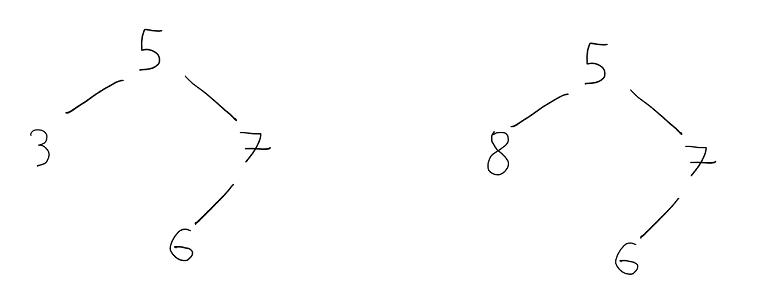

## Es. 3:

Scrivere una funzione `insert tree n` che prende un BST  e un intero, e restituisce il BST in cui è stato aggiunto quell'intero.

    let t = Node(5, Node(3, Empty, Empty), Node(7, Empty, Empty)) in
    insert t 6;;

    Output: Node(5, Node(3, Empty, Empty), Node(7, Node(6, Empty, Empty), Empty))

In [31]:
(*questo esercizio lo vedremo in classe nel tutorato successivo, il 9 novembre*)